# Deep Learning vs Traditional ML for Anomaly Detection

## General Imports

In [1]:
# Import libraries to verify installation
import seaborn as sns
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from datetime import datetime
from matplotlib.colors import Normalize
import tqdm
import PIL
import pickle
import sys
import json
from scipy.stats import skew
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import euclidean
from sklearn.metrics import roc_curve, auc

from fastdtw import fastdtw

import warnings
warnings.filterwarnings("ignore")

In [2]:
#path = "drive/MyDrive"
path = ""

## Dataset 

In [3]:
df = pd.read_csv('data.csv')

In [ ]:
print(df.shape)
df.head()

(5000000, 20)


,timestamp,aimp,amud,arnd,asin1,asin2,adbr,adfl,bed1,bed2,bfo1,bfo2,bso1,bso2,bso3,ced1,cfo1,cso1,y,category
0,2023-01-01 00:00:00,0.0,1.0,20.000000,0.00000,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,2023-01-01 00:00:01,0.0,1.0,20.080031,0.00002,0.0002,0.0,0.0,0.0,0.0,0.0,4.993912e-07,0.000789,0.0,0.0,0.0,0.000021,0.001229,0.0,0.0
2,2023-01-01 00:00:02,0.0,1.0,20.276562,0.00004,0.0004,0.0,0.0,0.0,0.0,0.0,1.496957e-06,0.003115,0.0,0.0,0.0,0.000104,0.004833,0.0,0.0
3,2023-01-01 00:00:03,0.0,1.0,20.730938,0.00006,0.0006,0.0,0.0,0.0,0.0,0.0,2.991484e-06,0.006914,0.0,0.0,0.0,0.000285,0.010688,0.0,0.0
4,2023-01-01 00:00:04,0.0,1.0,21.118101,0.00008,0.0008,0.0,0.0,0.0,0.0,0.0,4.981761e-06,0.012123,0.0,0.0,0.0,0.000601,0.018669,0.0,0.0


In [4]:
df = df.drop('timestamp', axis = 1)

## EDA and Preprocessing

In [5]:
# split the data into x and y dataframes

X_df = df.drop('y', axis=1)
y_df = df['y']

In [7]:
print(X_df.shape)
X_df.head()

(5000000, 18)


,aimp,amud,arnd,asin1,asin2,adbr,adfl,bed1,bed2,bfo1,bfo2,bso1,bso2,bso3,ced1,cfo1,cso1,category
0,0.0,1.0,20.000000,0.00000,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
1,0.0,1.0,20.080031,0.00002,0.0002,0.0,0.0,0.0,0.0,0.0,4.993912e-07,0.000789,0.0,0.0,0.0,0.000021,0.001229,0.0
2,0.0,1.0,20.276562,0.00004,0.0004,0.0,0.0,0.0,0.0,0.0,1.496957e-06,0.003115,0.0,0.0,0.0,0.000104,0.004833,0.0
3,0.0,1.0,20.730938,0.00006,0.0006,0.0,0.0,0.0,0.0,0.0,2.991484e-06,0.006914,0.0,0.0,0.0,0.000285,0.010688,0.0
4,0.0,1.0,21.118101,0.00008,0.0008,0.0,0.0,0.0,0.0,0.0,4.981761e-06,0.012123,0.0,0.0,0.0,0.000601,0.018669,0.0


In [8]:
print(y_df.shape)  
y_df.head() 

(5000000,)


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: y, dtype: float64

This section is dedicated to the exploratory data analysis of the dataset. Upon loading the dataset, we check its basic information.

In [9]:
# check for missing values

df.isnull().sum()

timestamp    0
aimp         0
amud         0
arnd         0
asin1        0
asin2        0
adbr         0
adfl         0
bed1         0
bed2         0
bfo1         0
bfo2         0
bso1         0
bso2         0
bso3         0
ced1         0
cfo1         0
cso1         0
y            0
category     0
dtype: int64

In [6]:
# load metadata csv

df_metadata = pd.read_csv('metadata.csv')

In [11]:
print(df_metadata.shape)
df_metadata.head()

(200, 5)


,start_time,end_time,root_cause,affected,category
0,2023-01-12 15:11:45,2023-01-12 15:20:05,bso3,['cfo1'],12
1,2023-01-12 16:27:46,2023-01-12 17:51:06,bso3,['cfo1'],1
2,2023-01-12 18:19:35,2023-01-12 18:36:15,bfo2,['cso1'],8
3,2023-01-12 20:46:32,2023-01-12 20:51:32,bed2,['ced1'],7
4,2023-01-13 05:57:10,2023-01-13 06:02:10,bfo1,['cfo1'],9


In [12]:
df_metadata.category.value_counts()

category
8     28
3     22
12    20
7     20
9     18
4     15
5     13
2     13
13    12
6     12
1     11
10    10
11     6
Name: count, dtype: int64

From the metadata, we can see that we have 200 batches of injected anomalies. And, in each batch, we can see the root cause of the anomaly.

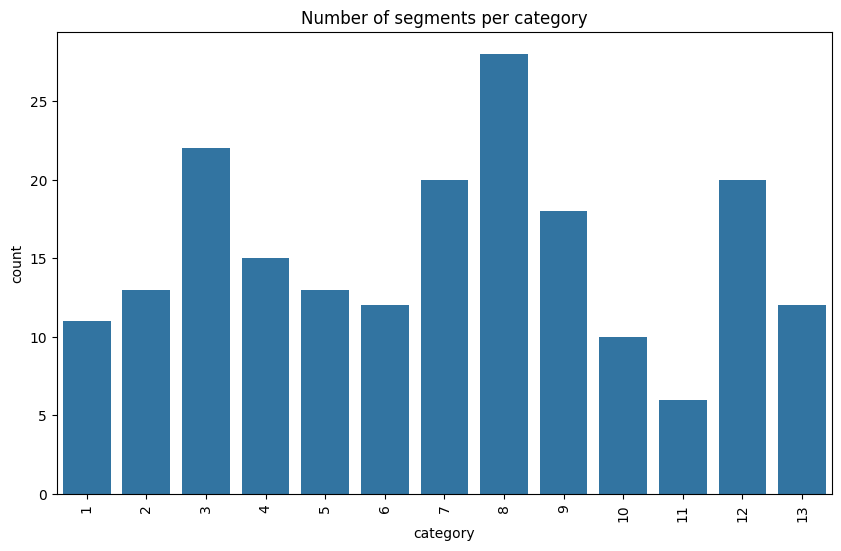

In [13]:
# Plot graph of categories

plt.figure(figsize=(10,6))

sns.countplot(x='category', data=df_metadata)

plt.title('Number of segments per category')

plt.xticks(rotation=90)

plt.show()

No missing values!

In [13]:
# check for class imbalance

y_df.value_counts()

y
0.0    4809900
1.0     190100
Name: count, dtype: int64

In [14]:
# check for labels in first 1000000 rows

y_df[:1000000].value_counts()

y
0.0    1000000
Name: count, dtype: int64

In [15]:
y_df[1000000:].value_counts()

y
0.0    3809900
1.0     190100
Name: count, dtype: int64

In [16]:
X_df['category'].value_counts()

category
0.0     4809900
8.0       32600
1.0       20400
12.0      19600
7.0       19100
3.0       18000
4.0       15600
6.0       12100
2.0       12000
9.0       10400
5.0        9900
11.0       9100
10.0       6400
13.0       4900
Name: count, dtype: int64

This is as expected as the first 1000000 rows are the normal data and the remaining 4000000 rows contain both normal and anomalous data. Futhermore each anomaly has its own category identified, which is listed in the metadata.

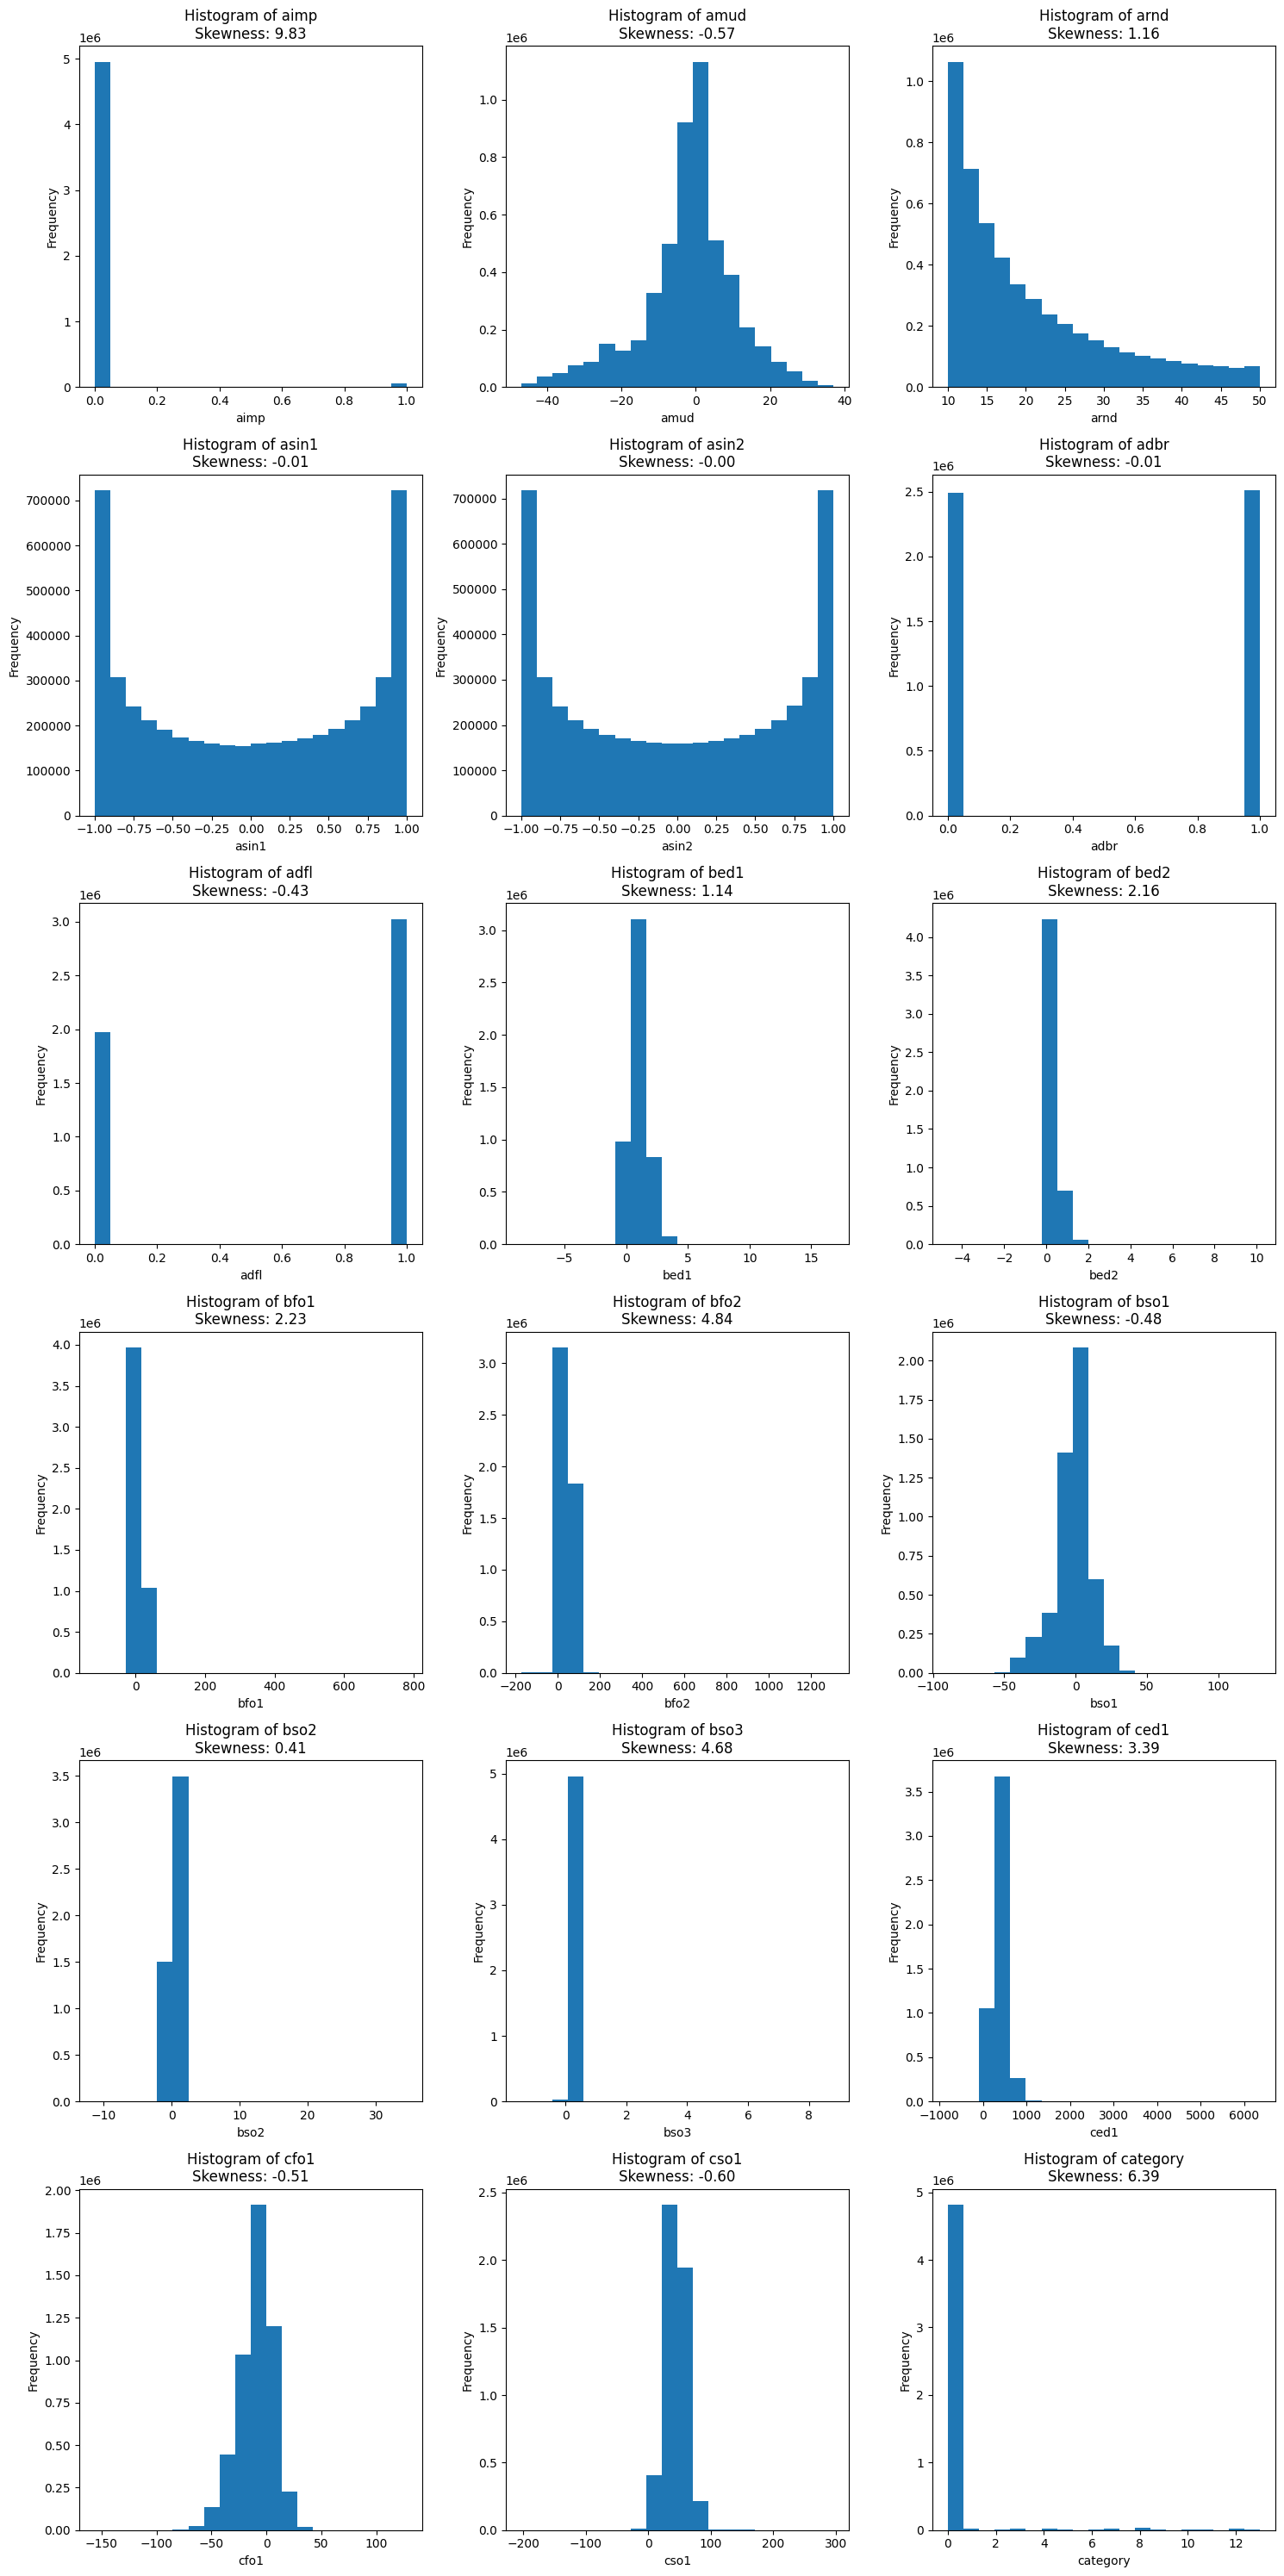

In [7]:
# Plot histograms for each numeric feature
numeric_features = X_df.select_dtypes(include=['float64', 'int64'])  # Select numeric features
numeric_columns = numeric_features.columns

num_plots = len(numeric_columns)
num_rows = int(np.ceil(num_plots/3)) # Adjust the number of rows as needed

fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

for i, column in enumerate(numeric_columns):
    row = i // 3
    col = i % 3
    axes[row, col].hist(X_df[column], bins=20)  # Adjust the number of bins as needed
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].set_title(f'Histogram of {column}\nSkewness: {skew(df[column]):.2f}')

# Remove empty subplots
if num_plots % 3 != 0:
    for i in range(num_plots % 3, 3):
        fig.delaxes(axes[num_rows-1, i])

plt.tight_layout()
plt.show()


In [8]:
# check the features for which number of unique values is small

discrete_features = [feature for feature in numeric_columns if len(X_df[feature].unique()) < 100]

for feature in discrete_features:
    print(f'{feature}: {X_df[feature].unique()}')

aimp: [0. 1.]
amud: [  1.  -1.   2.   3.   6.   5.   0.  10.   7.   4.  -4.   9.  11.   8.
  16.  12.  -3.  -6.  -5. -12. -13.  -7.  -9.  -2. -10. -11.  -8. -15.
 -14. -17. -19. -21. -24. -23. -22. -25. -28. -16. -20. -30. -29. -26.
 -27. -32. -31. -34. -37. -35. -18.  13.  15.  14.  18.  21.  22.  25.
  26.  30.  27.  24.  23.  29.  28.  20.  19.  17. -33. -41. -38. -39.
 -44. -45. -36. -40. -43. -46. -42. -47.  31.  32.  33.  34.  37.  36.
  35.]
adbr: [0. 1.]
adfl: [0. 1.]
category: [ 0. 12.  1.  8.  7.  9.  4.  3.  5. 11. 10.  2. 13.  6.]


From this, we gathered that other than `category`, we have 4 features which have discrete values. Therefore, we make sure not to normalize these features (we only want to normalize the continuous features).

### Data Preprocessing

We implement K fold time series split to ensure that the model is trained on the past and tested on the future. This is important as we are dealing with time series data.

Data preprocessing steps:
- Normalizing the continuous features
- Dropping highly correlated features (if any)
- Data augmentation on training sets

In [9]:
# Define the number of splits
n_splits = 4

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

# Perform the splits
fold = 0
for train_index, test_index in tscv.split(X_df):
    fold += 1
    X_train, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    y_train, y_test = y_df.iloc[train_index], y_df.iloc[test_index]
    
    print(f"Fold {fold}")
    print(f"TRAIN indices: {train_index}")
    print(f"TEST indices: {test_index}")

Fold 1
TRAIN indices: [     0      1      2 ... 999997 999998 999999]
TEST indices: [1000000 1000001 1000002 ... 1999997 1999998 1999999]
Fold 2
TRAIN indices: [      0       1       2 ... 1999997 1999998 1999999]
TEST indices: [2000000 2000001 2000002 ... 2999997 2999998 2999999]
Fold 3
TRAIN indices: [      0       1       2 ... 2999997 2999998 2999999]
TEST indices: [3000000 3000001 3000002 ... 3999997 3999998 3999999]
Fold 4
TRAIN indices: [      0       1       2 ... 3999997 3999998 3999999]
TEST indices: [4000000 4000001 4000002 ... 4999997 4999998 4999999]


In [10]:
# get contamination rates of train and test sets of all folds

contamination_rates = {}

for train_index, test_index in tscv.split(X_df):
    y_train, y_test = y_df.iloc[train_index], y_df.iloc[test_index]
    train_contamination_rate = np.mean(y_train)
    test_contamination_rate = np.mean(y_test)
    contamination_rates[f"Fold {len(contamination_rates)+1}"] = {
        "Train": train_contamination_rate,
        "Test": test_contamination_rate
    }

contamination_rates

{'Fold 1': {'Train': 0.0, 'Test': 0.049892},
 'Fold 2': {'Train': 0.024946, 'Test': 0.056508},
 'Fold 3': {'Train': 0.03546666666666667, 'Test': 0.0442},
 'Fold 4': {'Train': 0.03765, 'Test': 0.0395}}

#### Correlation Analysis

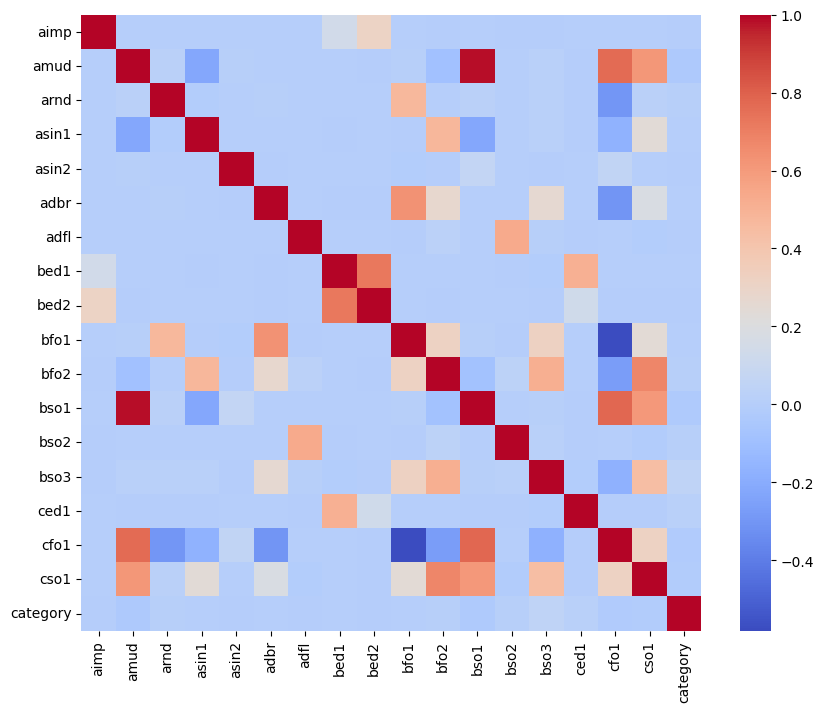

In [15]:
# check for correlation matrix between columns, using sns heatmap

corr = X_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', linecolor='black')
plt.show()

In [11]:
def preprocess_data(X_train, X_test, y_train=None, y_test=None, correlation_threshold=0.9):
    """
    Preprocess the data by scaling features, handling missing values, and dropping highly correlated features.
    
    Parameters:
    X_train (DataFrame): Training feature set.
    X_test (DataFrame): Test feature set.
    y_train (Series, optional): Training labels.
    y_test (Series, optional): Test labels.
    correlation_threshold (float): Threshold for dropping highly correlated features.
    
    Returns:
    X_train_scaled, X_test_scaled: Scaled and preprocessed training and test feature sets.
    """
    
    # Drop highly correlated features in the training set, display highly correlated features
    corr_matrix_train = X_train.corr().abs()
    upper = corr_matrix_train.where(np.triu(np.ones(corr_matrix_train.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
    print(f"Highly correlated features to drop for train set: {to_drop}")
    X_train_reduced = X_train.drop(columns=to_drop)

    corr_matrix_test = X_test.corr().abs()
    upper = corr_matrix_test.where(np.triu(np.ones(corr_matrix_test.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
    print(f"Highly correlated features to drop for test set: {to_drop}")
    X_test_reduced = X_test.drop(columns=to_drop)
    
    numeric_features = X_train_reduced.select_dtypes(include=['float64', 'int64'])  # Select numeric features
    numeric_columns = numeric_features.columns
    discrete_features = [feature for feature in numeric_columns if len(X_df[feature].unique()) < 100]
    continuous_features = [feature for feature in numeric_columns if feature not in discrete_features]

    scaler = StandardScaler()
    X_train_scaled = X_train_reduced.copy()
    X_train_scaled[continuous_features] = scaler.fit_transform(X_train_reduced[continuous_features])
    X_test_scaled = X_test_reduced.copy()
    X_test_scaled[continuous_features] = scaler.transform(X_test_reduced[continuous_features])
    
    return X_train_scaled, X_test_scaled

Now our dataset is standardized, with highly correlated features dropped, we can proceed with data augmentation on the train set. We will use the SMOTE technique to balance the dataset.

This represents a very imbalanced dataset, with the majority class being the normal data. So, clearly, data augmentation is necessary.

In [12]:
def augment_data(X_train, y_train):
    """
    Augment the training data using SMOTE.
    
    Parameters:
    X_train (array-like): Training feature set.
    y_train (array-like): Training labels.
    
    Returns:
    X_train_resampled, y_train_resampled: Augmented training feature set and labels.
    """
    if len(np.unique(y_train)) > 1:  # Check if there is more than one class
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        return X_train_resampled, y_train_resampled
    else:
        # If there's only one class, return the original data
        print("SMOTE not applied, only one class present.")
        return X_train, y_train

In [13]:
# Preprocess and augment the data for each fold
X_train_scaled, X_test_scaled = {}, {}
y_train_scaled, y_test_scaled = {}, {}
X_train_augmented, y_train_augmented = {}, {}

for fold, (train_index, test_index) in enumerate(tscv.split(X_df)):
    X_train, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    y_train, y_test = y_df.iloc[train_index], y_df.iloc[test_index]
    
    # Preprocess the data
    X_train_scaled[fold], X_test_scaled[fold] = preprocess_data(X_train, X_test, y_train, y_test)
    y_train_scaled[fold], y_test_scaled[fold] = y_train, y_test
    
    print(f"Fold {fold} preprocessing complete")
    print(X_train_scaled[fold].shape)
    print(X_test_scaled[fold].shape)
    
    # Augment the training data
    X_train_augmented[fold], y_train_augmented[fold] = augment_data(X_train_scaled[fold], y_train_scaled[fold])
    
    # Print shapes of the augmented training data
    print(f"Fold {fold} augmentation complete")
    print(f"Augmented Train Data Shape: {X_train_augmented[fold].shape}")
    print(f"Augmented Train Labels Shape: {y_train_augmented[fold].shape}")
    print("\n")

Highly correlated features to drop for train set: ['bso1']
Highly correlated features to drop for test set: ['bso1']
Fold 0 preprocessing complete
(1000000, 17)
(1000000, 17)
SMOTE not applied, only one class present.
Fold 0 augmentation complete
Augmented Train Data Shape: (1000000, 17)
Augmented Train Labels Shape: (1000000,)


Highly correlated features to drop for train set: ['bso1']
Highly correlated features to drop for test set: ['bso1']
Fold 1 preprocessing complete
(2000000, 17)
(1000000, 17)
Fold 1 augmentation complete
Augmented Train Data Shape: (3900216, 17)
Augmented Train Labels Shape: (3900216,)


Highly correlated features to drop for train set: ['bso1']
Highly correlated features to drop for test set: ['bso1']
Fold 2 preprocessing complete
(3000000, 17)
(1000000, 17)
Fold 2 augmentation complete
Augmented Train Data Shape: (5787200, 17)
Augmented Train Labels Shape: (5787200,)


Highly correlated features to drop for train set: ['bso1']
Highly correlated features to d

In [39]:
X_train = X_train_augmented
y_train = y_train_augmented

X_test = X_test_scaled
y_test = y_test_scaled

We have now finished preparing our datasets for training. 



---
# Models

## Traditional ML Models

### Isolation Forests

In [43]:
from sklearn.ensemble import IsolationForest

def train_isolation_forest(X_train, contamination='auto', n_estimators=100, random_state=42):
    """
    Train an Isolation Forest model.

    Parameters:
    X_train (DataFrame): Training feature set.
    contamination (float or str): Proportion of outliers in the dataset. Default is 'auto'.
    n_estimators (int): Number of base estimators in the ensemble. Default is 100.
    random_state (int): Random state for reproducibility. Default is 42.

    Returns:
    IsolationForest: The trained Isolation Forest model.
    """
    # Create an Isolation Forest instance
    clf = IsolationForest(n_estimators=n_estimators, max_samples='auto', contamination=contamination, random_state=random_state)
    
    # Fit the model on the training data
    clf.fit(X_train)
    
    return clf

In [44]:
# Train an Isolation Forest model for each fold

isolation_forest_models = {}

for fold in range(n_splits):
    isolation_forest_models[fold] = train_isolation_forest(X_train[fold])
    print(f"Fold {fold} Isolation Forest model trained")

Fold 0 Isolation Forest model trained
Fold 1 Isolation Forest model trained
Fold 2 Isolation Forest model trained
Fold 3 Isolation Forest model trained


In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_isolation_forest(model, X_test, y_test):
    """
    Evaluate the performance of an Isolation Forest model.

    Parameters:
    model (IsolationForest): Trained Isolation Forest model.
    X_test (DataFrame): Test feature set.
    y_test (Series): True labels for the test set.

    Returns:
    dict: A dictionary containing the evaluation metrics.
    """
    y_pred = model.predict(X_test)
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    y_prob = model.decision_function(X_test)
    inverted_y_prob = 1 - y_prob

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, inverted_y_prob)

    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

    return metrics


In [24]:
# evaluate the models for each fold

isolation_forest_metrics = {}

for fold in range(n_splits):
    isolation_forest_metrics[fold] = evaluate_isolation_forest(isolation_forest_models[fold], X_test[fold], y_test[fold])
    print(f"Fold {fold} Isolation Forest model evaluated")

Fold 0 Isolation Forest model evaluated
Fold 1 Isolation Forest model evaluated
Fold 2 Isolation Forest model evaluated
Fold 3 Isolation Forest model evaluated


In [46]:
# Display the evaluation metrics for each fold

isolation_forest_metrics_df = pd.DataFrame(isolation_forest_metrics).T

isolation_forest_metrics_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,0.762589,0.088216,0.402590,0.144721,0.649419
1,0.801715,0.201985,0.850251,0.326425,0.902272
2,0.802411,0.170351,0.896674,0.286309,0.922378
3,0.824046,0.140506,0.675089,0.232600,0.816962


In [47]:
# take average of evaluation metrics

isolation_forest_metrics_avg = isolation_forest_metrics_df.mean()

isolation_forest_metrics_avg

Accuracy     0.797690
Precision    0.150264
Recall       0.706151
F1 Score     0.247514
ROC AUC      0.822757
dtype: float64

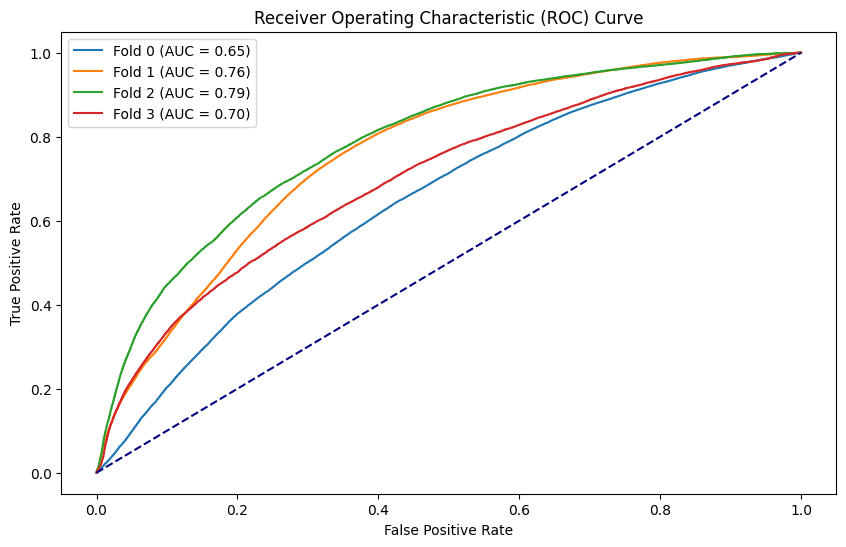

In [48]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 6))

for fold in range(n_splits):
    y_prob = isolation_forest_models[fold].decision_function(X_test[fold])
    fpr, tpr, _ = roc_curve(y_test[fold], 1 - y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f"Fold {fold} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [49]:
# plot confusion matrix

from sklearn.metrics import confusion_matrix, classification_report

for fold in range(n_splits):
    y_pred = isolation_forest_models[fold].predict(X_test[fold])
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test[fold], y_pred), index=['Actual Normal', 'Actual Anomaly'], columns=['Predicted Normal', 'Predicted Anomaly'])
    print(f"Fold {fold} Confusion Matrix:")
    print(confusion_matrix_df)
    print(classification_report(y_test[fold], y_pred))


Fold 0 Confusion Matrix:
                Predicted Normal  Predicted Anomaly
Actual Normal             742503             207605
Actual Anomaly             29806              20086
              precision    recall  f1-score   support

         0.0       0.96      0.78      0.86    950108
         1.0       0.09      0.40      0.14     49892

    accuracy                           0.76   1000000
   macro avg       0.52      0.59      0.50   1000000
weighted avg       0.92      0.76      0.83   1000000

Fold 1 Confusion Matrix:
                Predicted Normal  Predicted Anomaly
Actual Normal             884872              58620
Actual Anomaly             42715              13793
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95    943492
         1.0       0.19      0.24      0.21     56508

    accuracy                           0.90   1000000
   macro avg       0.57      0.59      0.58   1000000
weighted avg       0.91      0.90      

#### Gaussian Mixture Models

In [50]:
# run gaussian mixture models

from sklearn.mixture import GaussianMixture

def train_gaussian_mixture(X_train, n_components=1, covariance_type='full', random_state=42):

    """
    Train a Gaussian Mixture model.

    Parameters:
    X_train (DataFrame): Training feature set.
    n_components (int): Number of mixture components. Default is 1.
    covariance_type (str): Type of covariance parameters to use. Default is 'full'.
    random_state (int): Random state for reproducibility. Default is 42.

    Returns:
    GaussianMixture: The trained Gaussian Mixture model.
    """
    # Create a Gaussian Mixture instance
    gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=random_state)
    
    # Fit the model on the training data
    gmm.fit(X_train)
    
    return gmm

In [54]:
# Train a Gaussian Mixture model for each fold

gmm_models = {}

for fold in range(n_splits):
    gmm_models[fold] = train_gaussian_mixture(X_train[fold], n_components=5)
    print(f"Fold {fold} Gaussian Mixture model trained")

Fold 0 Gaussian Mixture model trained
Fold 1 Gaussian Mixture model trained
Fold 2 Gaussian Mixture model trained


MemoryError: Unable to allocate 999. MiB for an array with shape (7698800, 17) and data type float64

In [52]:
def evaluate_gaussian_mixtures(model, X_test, y_test):
    """
    Evaluate the performance of a Gaussian Mixture model.

    Parameters:
    model (GaussianMixture): Trained Gaussian Mixture model.
    X_test (DataFrame): Test feature set.
    y_test (Series): True labels for the test set.

    Returns:
    dict: A dictionary containing the evaluation metrics.
    """
    y_prob = model.score_samples(X_test)
    y_pred = model.predict(X_test)
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    inverted_y_prob = 1 - y_prob

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, inverted_y_prob)

    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

    return metrics

In [53]:
# evaluate the models for each fold

gmm_metrics = {}

for fold in range(n_splits):
    gmm_metrics[fold] = evaluate_gaussian_mixtures(gmm_models[fold], X_test[fold], y_test[fold])
    print(f"Fold {fold} Gaussian Mixture model evaluated")

# Display the evaluation metrics for each fold

gmm_metrics_df = pd.DataFrame(gmm_metrics).T

gmm_metrics_df

Fold 0 Gaussian Mixture model evaluated
Fold 1 Gaussian Mixture model evaluated
Fold 2 Gaussian Mixture model evaluated
Fold 3 Gaussian Mixture model evaluated


,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,0.950108,0.0,0.0,0.0,1.000000
1,0.943492,0.0,0.0,0.0,0.767823
2,0.955800,0.0,0.0,0.0,0.774666
3,0.960500,0.0,0.0,0.0,0.723936
